# Исследование поведения пользователей мобильного приложения

## Вводные данные

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. 

### Планы исследования

1. Изучим данные.
2. Проведем предобработку данных,проверим, что данные пользователей в А/А/B тесте не пересекаются
3. Изучим воронку событий проверим как ведут себя пользователи мобильного приложения
4. Изучим результаты эксперимента по внесению изменений в дизайн, проверим различие А/А/В теста
5. Подведем итоги

## Загрузка и подготовка данных к анализу

Загрузим необходимые библиотеки и переданный нам датасет

In [1]:
# импортируем необходимые нам библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as math
from statsmodels.stats.proportion import proportions_ztest
import collections
from collections import defaultdict
import datetime as dt
from cycler import cycler
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
from IPython.display import display, HTML
import warnings
import re


#введем некотрые настройки
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 400)
sns.set()
plt.rcParams.update({'figure.figsize': (15,8)})

#Подключим файлы с данными 

try:
    le = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    print('файл с данными не подключен')
else:
    print('файл с данными подключен')



файл с данными подключен


Согласно описанию данных предоставленому заказчиком:

Каждая запись в логе — это действие пользователя, или событие.

•	EventName — название события;

•	DeviceIDHash — уникальный идентификатор пользователя;

•	EventTimestamp — время события;

•	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


Проверим полученные данные

In [2]:
print('Таблица logs_exp (Информация о действиях пользователя)')
#Просмотрим общую информацию о данных

print (' ')
print ('Общая информация о данных')
le.info()

#Просмотрим данные функцией describle

print (' ')
print ('Описание данных')
print(le.describe())
print (' ')

# Применим случайную выборку данных для первичного ознакомления
# Укажем параметр random_state=1, для сохранения результата при повторных запусках алгоритма, если нам
# вдруг понадобится

print ('Случайная выборка данных')
le.sample(5, random_state=1)

Таблица logs_exp (Информация о действиях пользователя)
 
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
 
Описание данных
       DeviceIDHash  EventTimestamp          ExpId
count  2.441260e+05    2.441260e+05  244126.000000
mean   4.627568e+18    1.564914e+09     247.022296
std    2.642425e+18    1.771343e+05       0.824434
min    6.888747e+15    1.564030e+09     246.000000
25%    2.372212e+18    1.564757e+09     246.000000
50%    4.623192e+18    1.564919e+09     247.000000
75%    6.932517e+18    1.565075e+09     248.000000
max    9.222603e+18    1.565213e+09     248.000000
 
Случайная выборка данных


,EventName,DeviceIDHash,EventTimestamp,ExpId
120873,MainScreenAppear,9096061512161785646,1564917596,248
4103,OffersScreenAppear,1074933668878523996,1564631437,247
92724,OffersScreenAppear,8115340604306569112,1564838447,246
128891,CartScreenAppear,3163109716415429772,1564930563,246
186942,OffersScreenAppear,2405626918155135838,1565082344,247


В целом данные чистые. Проверим наличие дубликатов

In [3]:
print('\033[1m' + 'Количество пропусков:' + '\033[0m')
display(le.isna().sum())
print('=' * 45)
print()

print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m', 
      le.duplicated().sum())

Количество пропусков:


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


Количество явных дубликатов: 413


Посмотрим на дубликаты поподробнее:

In [4]:
#посмотрим на все дубликаты
le[le.duplicated(keep='first')]

,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


Выглядит как ошибка. Данных у нас достаточно и я думаю, что просто удалю эти дубликаты. 

In [5]:
#удалим дубликаты и проверим результат
le = le.drop_duplicates().reset_index(drop=True)
print('\033[1m' + 'Количество явных дубликатов:' + '\033[0m', le.duplicated().sum())
print (' ')
le.info()

Количество явных дубликатов: 0
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
EventName         243713 non-null object
DeviceIDHash      243713 non-null int64
EventTimestamp    243713 non-null int64
ExpId             243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Названия столбцов не самые удачные и могут повлечь ошибки - заменим названия столбцов на названия в одном регистре с подчеркиванием

In [6]:
# исправим регистр
le.columns = le.columns.str.lower()
# проверим результат
le.columns
print (' ')
le.info()

 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
eventname         243713 non-null object
deviceidhash      243713 non-null int64
eventtimestamp    243713 non-null int64
expid             243713 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


In [7]:
# переименуем столбцы
le = le.rename(columns = {'eventname': 'event_name', 
               'deviceidhash': 'id', 
               'eventtimestamp': 'event_timestamp', 
               'expid': 'group'})
# проверим результат
le.columns

Index(['event_name', 'id', 'event_timestamp', 'group'], dtype='object')

У нас есть время события  в формате Unix Timestamp. Для удобства дальнейшего анализа добавим столбец даты и времени в формате datetime, а также отдельный столбец дат.

In [8]:
# поменяем тип данных unix на datetime в отдельном столбце
le['event_time'] = pd.to_datetime(le['event_timestamp'], unit='s')
#выделим отдельный столбец с датой 
le['event_date'] = le['event_time'].dt.date
le['event_date'] = pd.to_datetime(le['event_date'])
#проверим результат
print(le.head(10))
le.info()

                event_name                   id  event_timestamp  group  \
0         MainScreenAppear  4575588528974610257       1564029816    246   
1         MainScreenAppear  7416695313311560658       1564053102    246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127    248   
3         CartScreenAppear  3518123091307005509       1564054127    248   
4  PaymentScreenSuccessful  6217807653094995999       1564055322    248   
5         CartScreenAppear  6217807653094995999       1564055323    248   
6       OffersScreenAppear  8351860793733343758       1564066242    246   
7         MainScreenAppear  5682100281902512875       1564085677    246   
8         MainScreenAppear  1850981295691852772       1564086702    247   
9         MainScreenAppear  5407636962369102641       1564112112    246   

           event_time event_date  
0 2019-07-25 04:43:36 2019-07-25  
1 2019-07-25 11:11:42 2019-07-25  
2 2019-07-25 11:28:47 2019-07-25  
3 2019-07-25 11:28:47 2019-07-25  

**Выводы** Мы подготовили данные к работе сними, переименовали столбца исключив возможность случайной опечатки, проверили пропуски и удалили полные дубликаты, а также добавили необходимые нам позднее столбцы с датой и временем события.

**Проведем предобработку данных** изучим и проверим их более внимательно. Хватает ли нам данных, за какой период они даны, нет ли нелогичных данных, нет ли пересечений между группами в А/А/В тестировании

Рассмотрим, сколько и какие события есть в логе

События в логе:
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


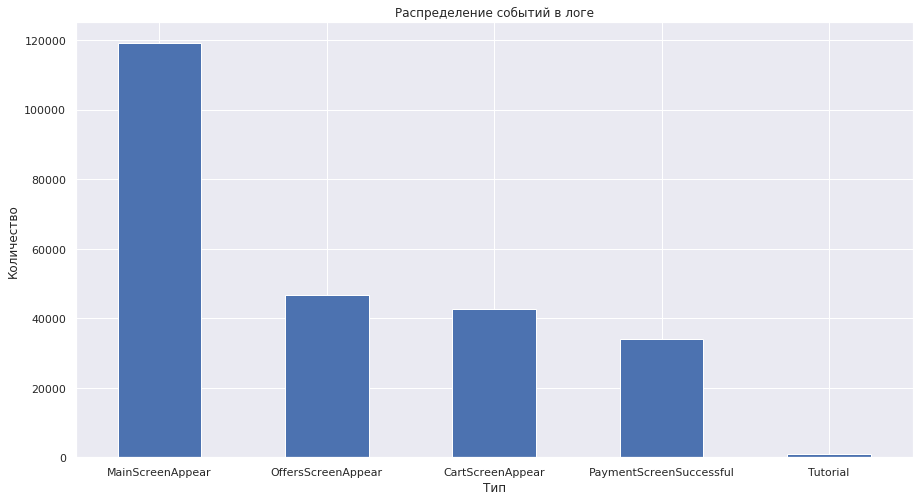

In [9]:
# посчитаем количество событий в логе
print('События в логе:')
print(le['event_name'].value_counts())

#построим график
le['event_name'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title('Распределение событий в логе')
plt.ylabel('Количество')
plt.xlabel('Тип')
plt.show()

У нас пять событий. Больше всего заходов на главную страницу, меньше всего чтений руководства :-). В принципе ничего странного. Вполне возможно, что руководство читают только когда что-то сломалось.

Описание событий Заказчик нам не предоставил, но из названий можно предположить что за события нам предоставлены:

'MainScreenAppear' - пользователь зашел на посадочную страницу, что-то думает и читает;

'OffersScreenAppear' - пользователь на странице предложения приложения;

'CartScreenAppear' - пользователь на странице "корзины" приложения;

'PaymentScreenSuccessful' - пользователь произвел оплату заказа;

'Tutorial' - пользователь почитал руководство :-).

Подсчитаем, сколько всего уникальных пользователей в логе:

In [10]:
# посчитаем количество уникальных пользователей в логе
print('Количество уникальных пользователей в логе:')
le['id'].nunique()

Количество уникальных пользователей в логе:


7551

Проверим сколько в среднем событий приходится на пользователя:

In [11]:
print('В среднем, пользователь совершил:')

print(round(le['event_name'].value_counts().sum() / le['id'].nunique(), 1))

В среднем, пользователь совершил:
32.3


Проверим, данные за какой период нам предоставили. Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. 

Максимальная дата события:  2019-08-07 21:15:17
Минимальная дата события:  2019-07-25 04:43:36
Сырые данные предоставлены за: 13 days 16:31:41


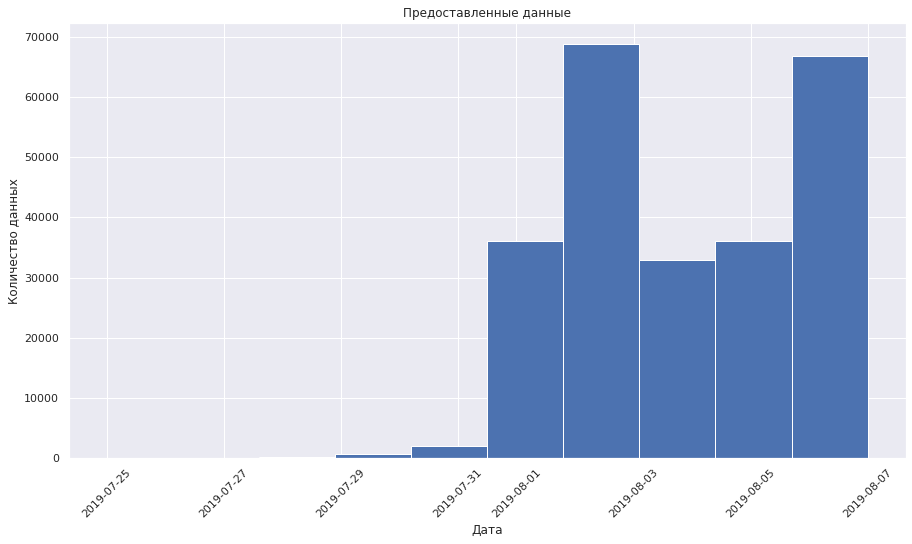

In [12]:
#выясним, даты данных
max_date = le['event_time'].max()
min_date = le['event_time'].min()
period = max_date - min_date
print('Максимальная дата события: ',max_date)
print('Минимальная дата события: ',min_date)
print('Сырые данные предоставлены за:',period)

le['event_date'].hist(bins=10)
plt.xticks(rotation=45)
plt.title('Предоставленные данные')
plt.ylabel('Количество данных')
plt.xlabel('Дата')
plt.show()

Очевидно, что у нас наблюдается небольшое количество неполных данных ранее 1.08.2019 года. Обычно для события хранятся два поля - дата отправки и дата приёма. Возможно данные для нас выгрузили по времени приёма, но в датасете оставили только время отправки.
Поскольку данных ранее 1.08.2019 не очень много, мы можем их просто отбросить.

In [13]:
type(le['event_date'])
le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
event_name         243713 non-null object
id                 243713 non-null int64
event_timestamp    243713 non-null int64
group              243713 non-null int64
event_time         243713 non-null datetime64[ns]
event_date         243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [14]:
#отбросим ненужные нам данные
mask = le['event_date'] >= '2019-08-01'
le_clear = le.loc[mask].reset_index(drop=True)
#проверим результат
le_clear.head()


,event_name,id,event_timestamp,group,event_time,event_date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [15]:
#проверим снова лимиты
max_date_clear = le_clear['event_time'].max()
min_date_clear = le_clear['event_time'].min()
period_clear = max_date_clear - min_date_clear
print('Максимальная дата события: ',max_date_clear)
print('Минимальная дата события: ',min_date_clear)
print('Сырые данные предоставлены за:',period_clear)

Максимальная дата события:  2019-08-07 21:15:17
Минимальная дата события:  2019-08-01 00:07:28
Сырые данные предоставлены за: 6 days 21:07:49


Похоже у нас есть данные только с утра 01.08.2019 по вечер 07.08.2019

Проверим, много ли событий и пользователей мы потеряли, отбросив старые данные:

In [16]:
print('Событий отбросили: ',len(le)-len(le_clear))
print('Пользователей отбросили: ',le['id'].nunique()-le_clear['id'].nunique())

Событий отбросили:  2826
Пользователей отбросили:  17


Мы отбросили примерно 1% событий - я думаю, это не повлияет на результаты исследования

Проверим, что у на есть пользователи из всех трёх экспериментальных групп, проверим - нет ли у нас одинаковых пользователей, которые оказались в разных группах

In [17]:
le_clear['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

In [18]:
#проверим дубликаты по группам
users_group = le_clear.groupby('id')['group'].nunique()

dubles = users_group[users_group > 1].index 

print('Задвоений в группах: ',len(dubles))

Задвоений в группах:  0


### Промежуточные выводы

Данные в целом пришли в хорошем виде. Присутсвовало небольшое количество дубликатов и некотрое количество неполных данных (данных до 01.08.2019). Поскольку их было небольшое количество, они были удалены из анализа. Задвоений пользователей по группам А/А/В тестирования не найдено. Данные готовы для анализа и проведения А/А/В теста

## Анализ данных

**Изучим воронку событий**

В процессе подготовки данных, мы увидели, что всего в логах у нас есть пять событий Описание событий Заказчик нам не предоставил, но из названий можно предположить что за события нам предоставлены:

'MainScreenAppear' - пользователь зашел на посадочную страницу, что-то думает и читает;

'OffersScreenAppear' - пользователь на странице предложения приложения;

'CartScreenAppear' - пользователь на странице "корзины" приложения;

'PaymentScreenSuccessful' - пользователь произвел оплату заказа;

'Tutorial' - пользователь почитал руководство.


Больше всего пользователи выходят на посадочную страницу, меньше всего читают инструкции. 
Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. 

In [19]:
# отсортируем количество событий в логе
print('События в логе:')
print(le_clear['event_name'].value_counts())

События в логе:
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [20]:
#сделаем копию данных для проработки воронки событий
vz = le_clear.copy()
print('Всего уникальных пользователей:',vz['id'].nunique())
print(' ')
print('Уникальные пользователи совершающие те или иные действия')
vz_act = vz.groupby('event_name')['id'].nunique().sort_values(ascending=False).reset_index()
vz_act

Всего уникальных пользователей: 7534
 
Уникальные пользователи совершающие те или иные действия


,event_name,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Думаю, что можно предположить следующую последовательность событий:
Пользователь заходит на главную страницу, некотрое время проводит там, возможно возвращается на страницу несколько раз.
Затем он выбирает нужные ему продукты изучает цены и думает над покупкой
На третьем шаге он оказывается в "корзине", где просматривает условия и заказ и решается на покупку.
После удачной оплаты он оказывается на странице успешной оплаты и радуется, что все оформил и оплатил.
Данные события выстраиваются в понятную последовательную цепочку. При этом у нас есть пользователи читающие руководство. Они могут делать это на любом этапе воронки и это собтие не встраивается в воронку. Думаю мы должны выключить его из расчета воронки.

Таким образом, я предлагаю следующую воронку событий:
'MainScreenAppear'
'OffersScreenAppear'
'CartScreenAppear'
'PaymentScreenSuccessful'

Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [21]:
#уберем события, которые мы не учитываем при создании воронки событий
mask1 = vz_act['event_name'] != 'Tutorial'
vz_act = vz_act.loc[mask1].reset_index(drop=True)

#проверим результат
print('События в логе:')
print(vz_act['event_name'])

События в логе:
0           MainScreenAppear
1         OffersScreenAppear
2           CartScreenAppear
3    PaymentScreenSuccessful
Name: event_name, dtype: object


In [22]:
#Вычислим доли пользователей
vz_act['transition_percent'] = vz_act['id'].div(vz_act['id'].shift(1))
vz_act['full_transition_percent'] = vz_act['id'] / vz_act['id'][0]
vz_act

,event_name,id,transition_percent,full_transition_percent
0,MainScreenAppear,7419,NaN,1.000000
1,OffersScreenAppear,4593,0.619086,0.619086
2,CartScreenAppear,3734,0.812976,0.503302
3,PaymentScreenSuccessful,3539,0.947777,0.477018


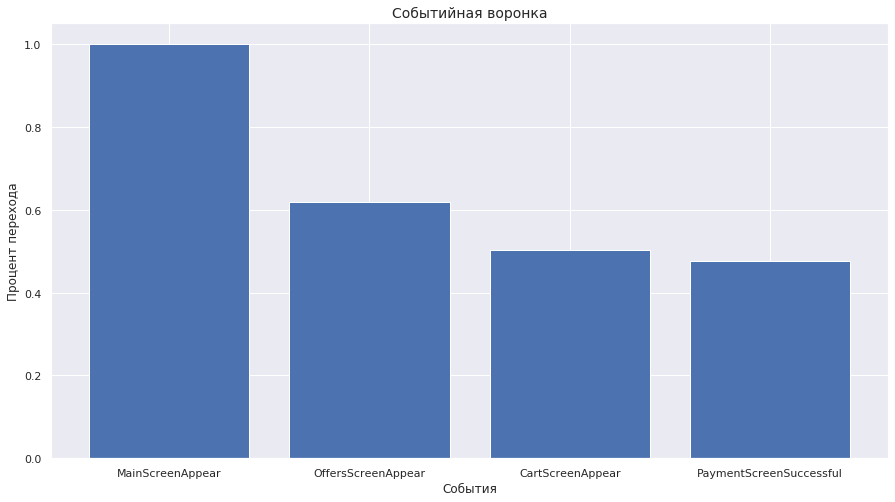

In [23]:
#построим график

x = vz_act['event_name']
y = vz_act['full_transition_percent']

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_title('Событийная воронка', fontsize=14)
ax.set_xlabel('События')
ax.set_ylabel('Процент перехода')

plt.show()

**Итог анализа событийной воронки**

Больше всего пользователей теряется на этапе формирования заказа - почти 38%. На остальных этапах потери пользователей заметно меньше. В целом от захода на посадочную страницу до страницы удачной оплаты добирается 48% пользователей. В целом - достойный результат.

**Изучим результаты эксперимента и подведем итоги**
Нам предоставлены данные по трем группам для подведения итогов А/А/В тестирования. В первую очередь нам нужно проверить количество пользователей в группах и отсутсвие статистической разницы между контрольными группами 246 и 247. Затем нам нужно проверить группу 248, которой был предоставлен вариант сайта с измененным шрифтом

In [24]:
#сделаем отдельный датафрейм для проведения проверки эксперимента
aab =le_clear.copy()
#проверим количество событий в группах
aab['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

In [25]:
#определим количество пользователей в группах
aab.pivot_table(index = 'group', values = 'id', aggfunc = 'nunique')

,group,id
group,,
246,1,2484
247,1,2513
248,1,2537


Количество уникальных пользователей в группах примерно одинаково. Ранее, на этапе подготовки данных, мы проверили отсутствие задвоения пользователей. Мы можем проверить разницу между контрольными выборками 246 и 247. Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, есть ли у нас статистически достоверное различие


Для проведения анализа установим уровень статистической значимости, равный 5% (alpha = 0.05). 

Также, определим гипотезы для проверки.

$H_0$ Статистически значимых различий между группами нет.

$H_1$ Статистически значимые различия между группами есть.


In [40]:
#сделаем функцию для автоматизации расчета

def ztest(group_1, group_2, transition, alpha):
    
    # подготовим переменные
    successes_1 = aab.query('event_name == @transition & group == @group_1')['id'].nunique()
    successes_2 = aab.query('event_name == @transition & group == @group_2')['id'].nunique()
    trials_1 = aab.query('event_name == "MainScreenAppear" & group == @group_1')['id'].nunique()
    trials_2 = aab.query('event_name == "MainScreenAppear" & group == @group_2')['id'].nunique()
    successes_combined = np.array([successes_1, successes_2])
    trials_combined = np.array([trials_1, trials_2])
    
    # проведём расчеты
    stat, p_val = proportions_ztest(successes_combined, trials_combined, alternative='two-sided')

    # выведем результаты
    print('p-значение: ',p_val.round(4))
    print(f'Доля пользователей, дошедших с посадочной страницы до страницы {transition}:')
    print(f'Для группы {group_1} - {successes_1/trials_1:.2%}')
    print(f'Для группы {group_2} - {successes_2/trials_2:.2%}')
    print(' ')
    if p_val < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 
    print(' ')

#вариант функции учитывающий всех уникальных пользователей
def ztest2(group_1, group_2, transition, alpha):
    
    # подготовим переменные
    successes_1 = aab.query('event_name == @transition & group == @group_1')['id'].nunique()
    successes_2 = aab.query('event_name == @transition & group == @group_2')['id'].nunique()
    trials_1 = aab.query('group == @group_1')['id'].nunique()
    trials_2 = aab.query('group == @group_2')['id'].nunique()
    successes_combined = np.array([successes_1, successes_2])
    trials_combined = np.array([trials_1, trials_2])
    
    # проведём расчеты
    stat, p_val = proportions_ztest(successes_combined, trials_combined, alternative='two-sided')

    # выведем результаты
    print('p-значение: ',p_val.round(4))
    print(f'Доля пользователей, сделавших событие {transition}:')
    print(f'Для группы {group_1} - {successes_1/trials_1:.2%}')
    print(f'Для группы {group_2} - {successes_2/trials_2:.2%}')
    print(' ')
    if p_val < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 
    print(' ')

Сделаем список всех событий, по которым будем проверять статистически достоверные различия. 

In [37]:
print('Всего уникальных пользователей:',vz['id'].nunique())
print(' ')
print('Уникальные пользователи совершающие те или иные действия')
vz_full = vz.groupby('event_name')['id'].nunique().sort_values(ascending=False).reset_index()
vz_full

Всего уникальных пользователей: 7534
 
Уникальные пользователи совершающие те или иные действия


,event_name,id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Самое популярное  событие это переход на главную страницу. Проверим статистически достоверное различие между группами 246 и 247 ( контрольные группы)

In [41]:
ztest2(246, 247, vz_full['event_name'][0],0.05)

p-значение:  0.7571
Доля пользователей, сделавших событие MainScreenAppear:
Для группы 246 - 98.63%
Для группы 247 - 98.53%
 
Не получилось отвергнуть нулевую гипотезу
 


Проверим остальные переходы в контрольных таблицах

In [42]:
for i in range(1, 5):
    ztest2(246, 247, vz_full['event_name'][i],0.05)

p-значение:  0.2481
Доля пользователей, сделавших событие OffersScreenAppear:
Для группы 246 - 62.08%
Для группы 247 - 60.49%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.2288
Доля пользователей, сделавших событие CartScreenAppear:
Для группы 246 - 50.97%
Для группы 247 - 49.26%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.1146
Доля пользователей, сделавших событие PaymentScreenSuccessful:
Для группы 246 - 48.31%
Для группы 247 - 46.08%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.9377
Доля пользователей, сделавших событие Tutorial:
Для группы 246 - 11.19%
Для группы 247 - 11.26%
 
Не получилось отвергнуть нулевую гипотезу
 


Судя по всему, наши контрольные группы подобраны правильно и не имеют статистически значимых различий

Сравним теперь контрольные группы (попеременно и совместно) с группой 248 которой показали измененный шрифт 

1) Сравним группы 246 и 248

In [30]:
for i in range(0, 5):
    ztest2(246, 248, vz_full['event_name'][i],0.05)

p-значение:  0.295
Доля пользователей, сделавших событие MainScreenAppear:
Для группы 246 - 98.63%
Для группы 248 - 98.27%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.2084
Доля пользователей, сделавших событие OffersScreenAppear:
Для группы 246 - 62.08%
Для группы 248 - 60.35%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.0784
Доля пользователей, сделавших событие CartScreenAppear:
Для группы 246 - 50.97%
Для группы 248 - 48.48%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.2123
Доля пользователей, сделавших событие PaymentScreenSuccessful:
Для группы 246 - 48.31%
Для группы 248 - 46.55%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.8264
Доля пользователей, сделавших событие Tutorial:
Для группы 246 - 11.19%
Для группы 248 - 11.00%
 
Не получилось отвергнуть нулевую гипотезу
 


1) Сравним группы 247 и 248

In [31]:
for i in range(0, 5):
    ztest2(247, 248, vz_full['event_name'][i],0.05)

p-значение:  0.4587
Доля пользователей, сделавших событие MainScreenAppear:
Для группы 247 - 98.53%
Для группы 248 - 98.27%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.9198
Доля пользователей, сделавших событие OffersScreenAppear:
Для группы 247 - 60.49%
Для группы 248 - 60.35%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.5786
Доля пользователей, сделавших событие CartScreenAppear:
Для группы 247 - 49.26%
Для группы 248 - 48.48%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.7373
Доля пользователей, сделавших событие PaymentScreenSuccessful:
Для группы 247 - 46.08%
Для группы 248 - 46.55%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.7653
Доля пользователей, сделавших событие Tutorial:
Для группы 247 - 11.26%
Для группы 248 - 11.00%
 
Не получилось отвергнуть нулевую гипотезу
 


1) Сравним объеденённую контрольную группу из групп 246 и 247 с группой 248

In [32]:
union_control = [246, 247]

In [33]:
for i in range(0, 5):
    ztest2(union_control, 248, vz_full['event_name'][i],0.05)

p-значение:  0.2942
Доля пользователей, сделавших событие MainScreenAppear:
Для группы [246, 247] - 98.58%
Для группы 248 - 98.27%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.4343
Доля пользователей, сделавших событие OffersScreenAppear:
Для группы [246, 247] - 61.28%
Для группы 248 - 60.35%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.1818
Доля пользователей, сделавших событие CartScreenAppear:
Для группы [246, 247] - 50.11%
Для группы 248 - 48.48%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.6004
Доля пользователей, сделавших событие PaymentScreenSuccessful:
Для группы [246, 247] - 47.19%
Для группы 248 - 46.55%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.7649
Доля пользователей, сделавших событие Tutorial:
Для группы [246, 247] - 11.23%
Для группы 248 - 11.00%
 
Не получилось отвергнуть нулевую гипотезу
 


Мы сделали двадцать проверок статистических гипотез при уровне значимости 5%, при этом нигде не получилось опровергнуть гипотезу о наличии статистически достоверной разницы между группами
Можно сделать проемжуточный вывод, что **не доказано влияние изменения шрифта на переходы с посадочной страницы** на последующие страницы воронки событий. 

### Промежуточные выводы

**Событийная воронка**

Думаю, что можно предположить следующую последовательность событий: Пользователь заходит на главную страницу, некотрое время проводит там, возможно возвращается на страницу несколько раз. Затем он выбирает нужные ему продукты изучает цены и думает над покупкой На третьем шаге он оказывается в "корзине", где просматривает условия и заказ и решается на покупку. После удачной оплаты он оказывается на странице успешной оплаты и радуется, что все оформил и оплатил. Данные события выстраиваются в понятную последовательную цепочку. При этом у нас есть пользователи читающие руководство. Они могут делать это на любом этапе воронки и это собтие не встраивается в воронку. Думаю мы должны выключить его из расчета воронки.

Таким образом, я предлагаю использовать следующую воронку событий: 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear' 'PaymentScreenSuccessful'

Больше всего пользователей теряется на этапе формирования заказа - почти 38%. На остальных этапах потери пользователей заметно меньше. В целом от захода на посадочную страницу до страницы удачной оплаты добирается 48% пользователей. В целом - достойный результат.

**А/А/В тестирование**
Нам предоставлены данные по трем группам для подведения итогов А/А/В тестирования. В первую очередь нам нужно проверить количество пользователей в группах и отсутсвие статистической разницы между контрольными группами 246 и 247. Затем нам нужно проверить группу 248, которой был предоставлен вариант сайта с измененным шрифтом

Мы сделали двадцать проверок статистических гипотез при уровне значимости 5%, при этом нигде не получилось опровергнуть гипотезу о наличии статистически достоверной разницы между группами
Можно сделать вывод, что **не доказано влияние изменения шрифта на переходы с посадочной страницы** на последующие страницы воронки событий. 

Предположим, что мы взяли слишком большой уровень значимости. Проверим несколько результатов при уровне значимости 0,15. 

In [34]:
for i in range(0, 5):
    ztest2(246, 247, vz_full['event_name'][i],0.15)

p-значение:  0.7571
Доля пользователей, сделавших событие MainScreenAppear:
Для группы 246 - 98.63%
Для группы 247 - 98.53%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.2481
Доля пользователей, сделавших событие OffersScreenAppear:
Для группы 246 - 62.08%
Для группы 247 - 60.49%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.2288
Доля пользователей, сделавших событие CartScreenAppear:
Для группы 246 - 50.97%
Для группы 247 - 49.26%
 
Не получилось отвергнуть нулевую гипотезу
 
p-значение:  0.1146
Доля пользователей, сделавших событие PaymentScreenSuccessful:
Для группы 246 - 48.31%
Для группы 247 - 46.08%
 
Отвергаем нулевую гипотезу
 
p-значение:  0.9377
Доля пользователей, сделавших событие Tutorial:
Для группы 246 - 11.19%
Для группы 247 - 11.26%
 
Не получилось отвергнуть нулевую гипотезу
 


Четвертая проверка показывает возможное расхождение в контрольных группах. Нам необходимо применить поправку на множественную проверку гипотез, как способ устранения эффекта множественных сравнений (с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода)

Применим поправку Бонферрони для расчета нужного нам уровня значимости:
Уровни значимости в каждом из $m$ сравнений в $m$ раз меньше, чем уровень значимости, требуемый при единственном сравнении.
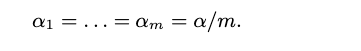

Мы провели 5 сравнений, соответсвенно сделаем проверочный расчет с (alpha = 0.15/5 = 0,03)

In [35]:
ztest2(246, 247, vz_full['event_name'][3],0.03)

p-значение:  0.1146
Доля пользователей, сделавших событие PaymentScreenSuccessful:
Для группы 246 - 48.31%
Для группы 247 - 46.08%
 
Не получилось отвергнуть нулевую гипотезу
 


Проверка с поправкой Бонферрони показала отсутсвие статичтически достоверной разницы между контрольными группами

## Выводы

Данные в целом пришли в хорошем виде. Присутсвовало небольшое количество дубликатов и некотрое количество неполных данных (данных до 01.08.2019). Поскольку их было небольшое количество, они были удалены из анализа. Задвоений пользователей по группам А/А/В тестирования не найдено. Данные готовы для анализа и проведения А/А/В теста

**Событийная воронка**

Думаю, что можно предположить следующую последовательность событий: Пользователь заходит на главную страницу, некотрое время проводит там, возможно возвращается на страницу несколько раз. Затем он выбирает нужные ему продукты изучает цены и думает над покупкой На третьем шаге он оказывается в "корзине", где просматривает условия и заказ и решается на покупку. После удачной оплаты он оказывается на странице успешной оплаты и радуется, что все оформил и оплатил. Данные события выстраиваются в понятную последовательную цепочку. При этом у нас есть пользователи читающие руководство. Они могут делать это на любом этапе воронки и это собтие не встраивается в воронку. Думаю мы должны выключить его из расчета воронки.

Таким образом, я предлагаю использовать следующую воронку событий: 'MainScreenAppear' 'OffersScreenAppear' 'CartScreenAppear' 'PaymentScreenSuccessful'

Больше всего пользователей теряется на этапе формирования заказа - почти 38%. На остальных этапах потери пользователей заметно меньше. В целом от захода на посадочную страницу до страницы удачной оплаты добирается 48% пользователей. В целом - достойный результат.

**А/А/В тестирование**
Нам предоставлены данные по трем группам для подведения итогов А/А/В тестирования. В первую очередь нам нужно проверить количество пользователей в группах и отсутсвие статистической разницы между контрольными группами 246 и 247. Затем нам нужно проверить группу 248, которой был предоставлен вариант сайта с измененным шрифтом

Мы сделали двадцать проверок статистических гипотез при уровне значимости 5%, при этом нигде не получилось опровергнуть гипотезу о наличии статистически достоверной разницы между группами
Можно сделать вывод, что **не доказано влияние изменения шрифта на переходы с посадочной страницы** на последующие страницы воронки событий. Дополнительно мы проверили расчеты с большим уровнем значимости и применением поправки Бонферрони.


**Рекомендации**
 Самый большой отток пользователей происходит на этапе перехода с посадочной страницы на страницу формирования заказа. Стоит проверить более пристально поведение посетителей на этом переходе.